In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Using one-hot encoding text in Keras

One-hot encoding is the most common, most basic way to turn a token into a vector. You already saw it in action in our initial IMDB example (done with words, in our case). It consists on associating a unique integer index to every word, then turning this integer index $i$ into a binary vector of size $N$, the size of the vocabulary, that would be all-zeros except for the i-th entry, which would be 1.

Note that Keras has built-in utilities for doing one-hot encoding text at the word level, starting from raw text data. This is what you should actually be using, as it will take care of a number of important features, such as stripping special characters from strings, or only taking into the top N most common words in your dataset (a common restriction to avoid dealing with very large input vector spaces).

Using Keras for word-level one-hot encoding begins by tokenizing the text (mapping a corpus of text into a list of IDs):

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# We create a tokenizer, configured to only take into account the top-10 most common words
tokenizer = Tokenizer(num_words=10)

# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
sequences = tokenizer.texts_to_sequences(samples)
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

Notice that the word "The" for instance has been mapped to the index 1 and the word dog has been mapped to the index 6.
This is how you can recover the word index that was computed

In [3]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index

Found 9 unique tokens.


{'the': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'mat': 5,
 'dog': 6,
 'ate': 7,
 'my': 8,
 'homework': 9}

Next, we transform the sequences of indexes into sequences of One hot encoded vectors

In [4]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical

maxID = max(map(lambda x: max(x), sequences))
for i,s in enumerate(sequences):
    print("One hot encoded version of:", samples[i], s)
    data = s
    data = array(data)
    # one hot encode
    encoded = to_categorical(data,num_classes=maxID+1)
    print(encoded)


One hot encoded version of: The cat sat on the mat. [1, 2, 3, 4, 1, 5]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
One hot encoded version of: The dog ate my homework. [1, 6, 7, 8, 9]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Make sure you understand the one hot encoded representation of our original sequences of text.

---

One hot encoding of text is extremely wasteful when you're working with large vocabularies. Remember that the length of the vectors is the size of the vocabulary, and every element in the vector will be a 0 except for one element that contains a 1.

Keras allows us to transform text into a more compact representation of a matrix in which each row represents a sentence and each column represents the index associated with the word. If a word is appears in a sentence, the column representing the word in the matrix will have an entry of 1.

Recall that we have previously transform two sentences of text into list of IDs:

In [5]:
print( samples )
sequences

['The cat sat on the mat.', 'The dog ate my homework.']


[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

We can now transform this representation into a compact matrix. Recall that each row represents a sentence and each column represents a word in our vocabulary.

In [6]:
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
one_hot_results

array([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]])

# Using word embeddings in Keras

---


Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

<img src="./images/ohVSwe.png" style="width: 400px;"/>


There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification, sentiment prediction,...). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

## Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance or the cosine similarity) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing 
task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are 
many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [7]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens (vocabulary size), here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors (word embeddings). It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a neural network.

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), and cut the reviews after only 120 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` layer on top for classification.

In [8]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features (i.e. vocabulary size)
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 120

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)` 
# Padded with zeros if sentence has less than 120 words
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

We take a look to the first two reviews:

In [9]:
x_train[:2]

array([[5244,   16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,
         619,    5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,
           6,   22,   12,  215,   28,   77,   52,    5,   14,  407,   16,
          82,    2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,
           7, 3766,    5,  723,   36,   71,   43,  530,  476,   26,  400,
         317,   46,    7,    4,    2, 1029,   13,  104,   88,    4,  381,
          15,  297,   98,   32, 2071,   56,   26,  141,    6,  194, 7486,
          18,    4,  226,   22,   21,  134,  476,   26,  480,    5,  144,
          30, 5535,   18,   51,   36,   28,  224,   92,   25,  104,    4,
         226,   65,   16,   38, 1334,   88,   12,   16,  283,    5,   16,
        4472,  113,  103,   32,   15,   16, 5345,   19,  178,   32],
       [   5,   89,   29,  952,   46,   37,    4,  455,    9,   45,   43,
          38, 1543, 1905,  398,    4, 1649,   26, 6853,    5,  163,   11,
        3215,    2,    4, 1153,    9,  194,

We create our model. Notice the embedding layer at the base of the model:

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())
# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))

Now we train the model:

In [11]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 8)            80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 961       
Total params: 80,961
Trainable params: 80,961
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 37us/step - loss: 0.6037 - acc: 0.6974 - val_loss: 0.4346 - val_acc: 0.8234
Epoch 2/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.3436 - acc: 0.8626 - val_loss: 0.3292 - val_acc: 0.8604
Epoch 3/10
20000/20000 [==============================] - 1s 29us/step - loss: 

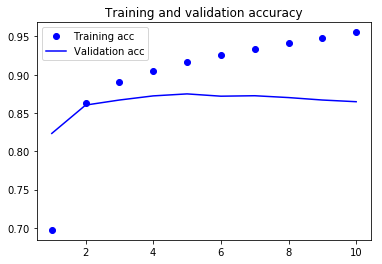

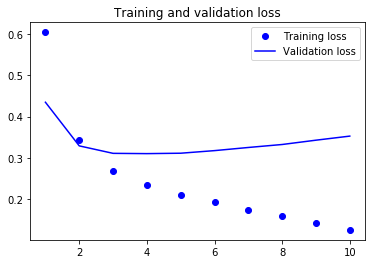

In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We get to a validation accuracy of ~86%, which is pretty good. But note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both *"this movie is shit"* and *"this movie is the shit"* as being negative "reviews"). It would be much better to add recurrent layers on top of the embedded sequences to learn features that take into account each sequence as a whole. Such a recurrent neural network with memory of the past will be the topic of future lectures.

## When not enough data is available

Notice that we have been using lots of data for creating a good model. The previous model was trained on 20,000 movie reviews. What would happen if we would have much less data, like only 200 reviews?

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

del model #Delete the previous model
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

#Notice that we only use the first 200 instances in our data set for training
history = model.fit(x_train[:200], y_train[:200],
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 8)            80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 961       
Total params: 80,961
Trainable params: 80,961
Non-trainable params: 0
_________________________________________________________________
Train on 160 samples, validate on 40 samples
Epoch 1/10
160/160 [==============================] - 0s 957us/step - loss: 0.6897 - acc: 0.5625 - val_loss: 0.6924 - val_acc: 0.5250
Epoch 2/10
160/160 [==============================] - 0s 44us/step - loss: 0.6636 - acc: 0.8875 - val_loss: 0.6919 - val_acc: 0.4750
Epoch 3/10
160/160 [==============================] - 0s 44us/step - loss: 0.6437 - acc: 0

With very little training data available, our model doesn't learn much. The validation accuracy is around 50%, the same that we would get with random guessing the sentiment of a movie. Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we picked.

## Using pre-trained word embeddings


What to do then when you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding of your vocabulary. 

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a different problem.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one of them. 

Let's take a look at how you can get started using word2vec embeddings in a Keras model. We will also use this example to refresh the text tokenization techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

Load the word2vec word embeddings by simply pointing towards the location of the model file in your computer. You can find a trained word2vec model `GoogleNews-vectors-negative300.bin` at: `I:\COURSES\ITP\BITY3\IN726-dsmi-data`

In [15]:
from gensim.models import KeyedVectors
filename = './GoogleNews-vectors-negative300.bin' 
modelwv = KeyedVectors.load_word2vec_format(filename, binary=True)

C:\Users\drozado\miniconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Let's transform the word2vec model data structure `modelwv` into a numpy matrix that keras can understand.

In [16]:
import numpy as np
embedding_dim = modelwv.vector_size
max_words = 10000  # We will only consider the top 10,000 words in the dataset
# convert the wv word vectors into a numpy matrix that is suitable for insertion
# into our TensorFlow and Keras models
embedding_matrix = np.zeros((max_words, embedding_dim))
for i in range(max_words):
    embedding_vector = modelwv[modelwv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

del model #Delete previous model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
#model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 300)          3000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 36000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 36001     
Total params: 3,036,001
Trainable params: 3,036,001
Non-trainable params: 0
_________________________________________________________________


### Load the word2vec embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with index `i`. Simple enough. Let's just load the word2vec matrix we prepared `embedding_matrix` into our `Embedding` layer, the first layer in our model:

In [18]:
model.layers[0].set_weights([embedding_matrix[:max_words]])


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

In [19]:
model.layers[0].trainable = False

### Train and evaluate

Let's compile our model and train it:

In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train[:200], y_train[:200],
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2
                    )

Train on 160 samples, validate on 40 samples
Epoch 1/5
160/160 [==============================] - 0s 1ms/step - loss: 0.6960 - acc: 0.5500 - val_loss: 0.6609 - val_acc: 0.5750
Epoch 2/5
160/160 [==============================] - 0s 112us/step - loss: 0.2828 - acc: 0.9813 - val_loss: 0.6606 - val_acc: 0.5000
Epoch 3/5
160/160 [==============================] - 0s 106us/step - loss: 0.1839 - acc: 1.0000 - val_loss: 0.6861 - val_acc: 0.5750
Epoch 4/5
160/160 [==============================] - 0s 100us/step - loss: 0.1248 - acc: 1.0000 - val_loss: 0.6717 - val_acc: 0.5750
Epoch 5/5
160/160 [==============================] - 0s 137us/step - loss: 0.0924 - acc: 1.0000 - val_loss: 0.6816 - val_acc: 0.5750


So using pre-train word embeddings improves performance a bit but not too much. Training the rest of the network with so little data it's hard.

## Putting it all together: from raw text to word embeddings

We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a `Dense` layer on top. But instead of using the pre-tokenized IMDB data packaged in Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset") or take it from `I:\COURSES\ITP\BITY3\IN726-dsmi-data\aclImdb.rar`. Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [58]:
import os

imdb_dir = './aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Let's take a look at the first movie review:

In [59]:
texts[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

And its corresponding labeled sentiment:

In [60]:
labels[0]

0

### Tokenize the data

Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

In [61]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 120  # We will cut reviews after 100 words
training_samples = 20000  # We will be training on 200 samples
validation_samples = 5000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

In [62]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: training_samples + validation_samples]
y_test = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 120)
Shape of label tensor: (25000,)


In [63]:
x_train[0]

array([ 474,  809,    9,   13,    3, 9374,   36,  377,    5, 1359,   15,
         69,    2,   48,   32, 1046, 1362,    9,   13,    7,    7,   14,
        512,   14,   10, 1922,    1, 1807,   20,   10,  694,  614,   48,
         10,   13,    8,   15,   40,   31,    1,  422, 7908,  258,   46,
        180,   89,  759,   53,   51,   22, 1662,  196,  198,    9,    6,
        128, 1290, 2139,   47,   68,   54,  757,   41,    1,    8, 7513,
       7422,   39,    1,  757,    4, 6737, 3254,   18,  276,   10,  771,
        185,  227,  192,   80,    1,  198,   15,   95,    5, 1258,  135,
          7,    7,   10,  383,   11,  120,    5,  256,   34, 1387,    1,
       2520, 2129,    2, 4717, 5369,    4,  260,  179,   11,  120,    6,
         52,  218,    2,   77,   25,   22, 1783,    5,  103,   50])

In [69]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 8
del model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 120, 8)            80000     
_________________________________________________________________
flatten_14 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                30752     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 110,785
Trainable params: 110,785
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=4,
                    batch_size=32,
                    validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/4
16000/16000 [==============================] - 1s 66us/step - loss: 0.5329 - acc: 0.7256 - val_loss: 0.3621 - val_acc: 0.8427
Epoch 2/4
16000/16000 [==============================] - 1s 39us/step - loss: 0.2676 - acc: 0.8926 - val_loss: 0.3363 - val_acc: 0.8585
Epoch 3/4
16000/16000 [==============================] - 1s 40us/step - loss: 0.1828 - acc: 0.9303 - val_loss: 0.3523 - val_acc: 0.8545
Epoch 4/4
16000/16000 [==============================] - 1s 39us/step - loss: 0.1164 - acc: 0.9601 - val_loss: 0.4074 - val_acc: 0.8472


let's evaluate the model:

In [71]:
model.evaluate(x_test, y_test)

5000/5000 [==============================] - 0s 12us/step


[0.3817607293605804, 0.8556]

And there you have it! you created a machine learning system able to carry out sentiment analysis with decent accuracy, starting from raw text!